# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('../data/user-item-interactions.csv')
df_content = pd.read_csv('../data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [161]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [162]:
print('Number of distinct users in the community: {}'.format(len(df.email.unique())))

Number of distinct users in the community: 5149


In [163]:
# Are there missing values in the email column?
print('There are {} email entries missing.'.format(pd.isna(df.email).sum()))
# Yes, these values are not removed yet, as a function exists 

There are 17 email entries missing.


In [164]:
# Converting the hashed email to an unique user id
labels, __ = pd.factorize(df.email) 
df['user_id'] = labels
# Solution found on Stackoverflow
# - https://stackoverflow.com/questions/25963431/convert-pandas-series-from-string-to-unique-int-ids
# - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html
assert len(df.email.unique()) == len(df.user_id.unique())

#df = df.drop('email', axis = 1)

(array([4.134e+03, 4.840e+02, 2.150e+02, 1.260e+02, 6.000e+01, 4.100e+01,
        2.000e+01, 2.000e+01, 1.500e+01, 1.000e+01, 4.000e+00, 2.000e+00,
        2.000e+00, 4.000e+00, 6.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  1.        ,  11.08333333,  21.16666667,  31.25      ,
         41.33333333,  51.41666667,  61.5       ,  71.58333333,
         81.66666667,  91.75      , 101.83333333, 111.91666667,
        122.        , 132.08333333, 142.16666667, 152.25      ,
        162.33333333, 172.41666667, 182.5       , 192.58333333,
        202.66666667, 212.75      , 222.83333333, 232.91666667,
        243.        , 253.08333333, 263.16666667, 273.25      ,
        283.33333333, 293.41666667, 303.5       , 313.58333333,
        323.66666667, 333.75      , 343.83

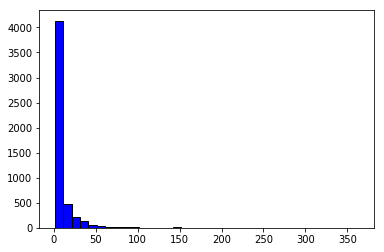

In [166]:
tmp = [[]]
for user_id, b in df.groupby(by = ['user_id'])['article_id']:
    tmp[0].append(b.shape)
    
# matplotlib histogram
plt.hist(df.groupby(by = ['user_id'])['article_id'].count(), color = 'blue', edgecolor = 'black',
         bins = int(180/5))


In [167]:
df.groupby(by = ['user_id'])['article_id'].count().median()

3.0

In [168]:
# Fill in the median and maximum number of user_article interactios below
median_val = df.groupby(by = ['user_id'])['article_id'].count().median()# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby(by = ['user_id'])['article_id'].count().max()# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [169]:
# Find and explore duplicate articles
print('There are {} entries which are completely identical.'.format(df_content.duplicated(keep = 'first').sum()))
print('{} articles have a duplicated id.'.format(df_content.shape[0] - len(df_content.article_id.unique())))
duplicates = df_content.duplicated(subset='article_id',keep = 'first')

# Which indexes contain a duplicated entry?
print(duplicates[duplicates == True].index)

## Get the article_id of the duplicated entries
#print(df_content.loc[duplicates[duplicates == True].index[1]])

#print(df_content[df_content['article_id']==50])
# articles differ in the doc_description

There are 0 entries which are completely identical.
5 articles have a duplicated id.
Int64Index([365, 692, 761, 970, 971], dtype='int64')
doc_body           Homepage Follow Sign in / Sign up Homepage * H...
doc_description    One of the earliest documented catalogs was co...
doc_full_name      How smart catalogs can turn the big data flood...
doc_status                                                      Live
article_id                                                       221
Name: 692, dtype: object
                                              doc_body  \
50   Follow Sign in / Sign up Home About Insight Da...   
365  Follow Sign in / Sign up Home About Insight Da...   

                                       doc_description  \
50                        Community Detection at Scale   
365  During the seven-week Insight Data Engineering...   

                    doc_full_name doc_status  article_id  
50   Graph-based machine learning       Live          50  
365  Graph-based machine

In [170]:
# Remove any rows that have the same article_id - only keep the first
print('Before dropping: ',df_content.shape)
df_content = df_content.drop_duplicates(subset = 'article_id',keep = 'first')
print('After dropping: ', df_content.shape)

Before dropping:  (1056, 5)
After dropping:  (1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [190]:
unique_articles = len(df.article_id.unique())# The number of unique articles that have at least one interaction
total_articles = len(df_content.article_id.unique())# The number of unique articles on the IBM platform
unique_users = len(df.user_id.unique())-1 # The number of unique users (-1 for the empty user_id)
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [173]:
most_viewed_article_id = str(df.article_id.value_counts(sort = True).index[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts(sort = True).iloc[0]# The most viewed article in the dataset was viewed how many times?

In [174]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [191]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!
